In [26]:
from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob


vector.register_awkward()

# 모든 .root 파일 경로 가져오기
path = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-3000_MN-2900_13p6TeV/"
file_list = sorted(glob.glob(path + "*.root"))

def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]

def btagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btagging[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btagging[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj.eta) < etamax and obj.pt > ptmin : output.append(obj)
    return output 


all_combined_p4 = []
all_mN = []
all_ak8_deltaR = []
all_mll = []
all_final_muon1_pt = []
all_final_muon2_pt = []
all_final_toptagged_ak8_pt = []
all_final_bjet_ak8_pt = []

# tqdm으로 파일 리스트 순회
for sample in tqdm(file_list, desc="Processing ROOT files"):

    file = uproot.open(sample)
    events = file["Events"]

    keys = events.keys()

    vector.register_awkward()

    lhe_pdgid = events["LHEPart_pdgId"].array()
    lhe_pt = events["LHEPart_pt"].array()
    lhe_eta = events["LHEPart_eta"].array()
    lhe_phi = events["LHEPart_phi"].array()
    lhe_mass = events["LHEPart_mass"].array()

    bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
    lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

    lhe_particle = ak.zip({
        "pt": lhe_pt,
        "eta": lhe_eta,
        "phi": lhe_phi,
        "mass": lhe_mass
    }, with_name="Momentum4D")

    lhe_bottoms = lhe_particle[bottom_mask]
    lhe_bottoms_eta = lhe_bottoms["eta"][:, 1:2]
    lhe_bottoms_phi = lhe_bottoms["phi"][:, 1:2]
    lhe_bottoms_pt = lhe_bottoms["pt"][:, 1:2]
    lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]  # bottom quark 1 = WR* mother

    lhe_bottom2_eta = lhe_bottoms["eta"][:, 0:1]
    lhe_bottom2_phi = lhe_bottoms["phi"][:, 0:1]
    lhe_bottom2_pt = lhe_bottoms["pt"][:, 0:1]
    lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]  # top mother bottom quark

    lhe_bottom = ak.zip({
        "eta": lhe_bottoms_eta,
        "phi": lhe_bottoms_phi,
        "pt": lhe_bottoms_pt,
        "mass": lhe_bottoms_mass
    }, with_name="Momentum4D")

    lhe_bottom2 = ak.zip({
        "eta": lhe_bottom2_eta,
        "phi": lhe_bottom2_phi,
        "pt": lhe_bottom2_pt,
        "mass": lhe_bottom2_mass
    }, with_name="Momentum4D")

    lhe_muons = lhe_particle[lhe_muon_mask]
    lhe_muons_eta = lhe_muons["eta"][:]
    lhe_muons_phi = lhe_muons["phi"][:]
    lhe_muons_pt = lhe_muons["pt"][:]
    lhe_muons_mass = lhe_muons["mass"][:]

    n_mother_muon_mass = lhe_muons_mass[:, 0:1]
    n_mother_muon_pt = lhe_muons_pt[:, 0:1]
    n_mother_muon_eta = lhe_muons_eta[:, 0:1]
    n_mother_muon_phi = lhe_muons_phi[:, 0:1]

    wr_mother_muon_mass = lhe_muons_mass[:, 1:2]
    wr_mother_muon_pt = lhe_muons_pt[:, 1:2]
    wr_mother_muon_eta = lhe_muons_eta[:, 1:2]
    wr_mother_muon_phi = lhe_muons_phi[:, 1:2]

    lhe_muon = ak.zip({
        "pt": lhe_muons_pt,
        "eta": lhe_muons_eta,
        "phi": lhe_muons_phi,
        "mass": lhe_muons_mass
    }, with_name="Momentum4D")

    n_mother_muon = ak.zip({
        "pt": n_mother_muon_pt,
        "eta": n_mother_muon_eta,
        "phi": n_mother_muon_phi,
        "mass": n_mother_muon_mass
    }, with_name="Momentum4D")

    wr_mother_muon = ak.zip({
        "pt": wr_mother_muon_pt,
        "eta": wr_mother_muon_eta,
        "phi": wr_mother_muon_phi,
        "mass": wr_mother_muon_mass
    }, with_name="Momentum4D")

    genparticle_pdgid = events["GenPart_pdgId"].array()
    genparticle_pt = events["GenPart_pt"].array()
    genparticle_eta = events["GenPart_eta"].array()
    genparticle_phi = events["GenPart_phi"].array()
    genparticle_mass = events["GenPart_mass"].array()
    genparticle_statusFlags = events["GenPart_statusFlags"].array()

    top_mask = (genparticle_pdgid == 6) | (genparticle_pdgid == -6)

    genparticle = ak.zip({
        "pt": genparticle_pt,
        "eta": genparticle_eta,
        "phi": genparticle_phi,
        "mass": genparticle_mass
    }, with_name="Momentum4D")

    gentops = genparticle[top_mask]
    gentops_eta = gentops["eta"][:, 0:1]
    gentops_phi = gentops["phi"][:, 0:1]
    gentops_pt = gentops["pt"][:, 0:1]
    gentops_mass = gentops["mass"][:, 0:1]

    gentop = ak.zip({
        "eta": gentops_eta,
        "phi": gentops_phi,
        "pt": gentops_pt,
        "mass": gentops_mass
    }, with_name="Momentum4D")

    ### reco level
    ak4_eta = events["Jet_eta"].array()
    ak4_phi = events["Jet_phi"].array()
    ak4_pt = events["Jet_pt"].array()
    ak4_flavor = events["Jet_hadronFlavour"].array()
    ak4_mass = events["Jet_mass"].array()
    btag = events["Jet_btagPNetB"].array()

    ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name="Momentum4D")

    ## Fatjet 
    fatjet_pt = events["FatJet_pt"].array()
    fatjet_eta = events["FatJet_eta"].array()
    fatjet_phi = events["FatJet_phi"].array()
    fatjet_mass = events["FatJet_mass"].array()

    fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

    ## muons
    reco_muon_pt = events["Muon_pt"].array()
    reco_muon_eta = events["Muon_eta"].array()
    reco_muon_phi = events["Muon_phi"].array()
    reco_muon_mass = events["Muon_mass"].array()

    reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name="Momentum4D")

    btagging = events["FatJet_btagDeepB"].array()
    toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
    softdrop_mass = events["FatJet_msoftdrop"].array()

    closest_muon1 = find_closest_jet(n_mother_muon, reco_muons)
    closest_muon2 = find_closest_jet(wr_mother_muon, reco_muons)
    closest_bjet = find_closest_jet(lhe_bottom, ak4)
    closest_bak8jet = find_closest_jet(lhe_bottom, fatjets)
    closest_ak8jet = find_closest_jet(gentop, fatjets)
    notcleaned_mass = closest_muon1 + closest_muon2 + closest_bjet + closest_ak8jet

    #####################################################
    cleaned_Nmother_muon_pt = []
    cleaned_WR_mother_muon_pt = []
    all_muon_pt = []
    cleaned_ak4jet_pt = []
    all_ak4jet_pt = []
    cleaned_ak8jet_pt = []
    all_ak8jet_pt = []
    #####################################################

    first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
    second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온
    topmother_b_ak4jet = find_closest_jet(lhe_bottom2, ak4)

    ### 겹치는거 확인 
    first_muon_cleaned = overlap_removal(first_muon, [reco_muons], cut=0.4)
    second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)

    signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned, second_muon_cleaned], cut=0.8)
    toptaggedak8 = toptagging_overlap_removal(fatjets, [first_muon_cleaned, second_muon_cleaned], cut=0.8)
    softdrop_mass_ak8 = sdm_toptagging_overlap_removal(fatjets, [first_muon_cleaned, second_muon_cleaned], cut=0.8)
    btaggingak8 = btagging_overlap_removal(fatjets, [first_muon_cleaned, second_muon_cleaned], cut=0.8)

    idx_desc = ak.argsort(-signaltop_cleaned["pt"], axis=1)

    toptagging_mask = toptaggedak8 > 0.9  # ParticleNet T vs QCD threshold
    softdrop_mass_mask = softdrop_mass_ak8 > 120  # SoftDrop mass threshold
    total_top_mask = toptagging_mask & softdrop_mass_mask
    #print(total_top_mask)

    cleaned_toptagged_ak8 = signaltop_cleaned[total_top_mask]  # top tagging 된 애들만 남김
    idx_cleaned_toptagged_ak8 = ak.argsort(-cleaned_toptagged_ak8["pt"], axis=1)
    leading_toptagged_ak8 = cleaned_toptagged_ak8[idx_cleaned_toptagged_ak8][:, 0:1]

    ## top을 제외한 나머지 ak8 중 제일 큰 pt
    cleaned_bjet_ak8 = signaltop_cleaned[~toptagging_mask]
    idx_cleaned_bjet_ak8 = ak.argsort(-cleaned_bjet_ak8["pt"], axis=1)
    leading_bjet_ak8 = cleaned_bjet_ak8[idx_cleaned_bjet_ak8][:, 0:1]

    #print(leading_toptagged_ak8["pt"])
    #print(leading_bjet_ak8["pt"])

    first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
    second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
    firstsorted_toptagged_ak8_pt = ak.sum(leading_toptagged_ak8["pt"], axis=1)
    firstsorted_bjet_ak8_pt = ak.sum(leading_bjet_ak8["pt"], axis=1)

    leftmask = (
        (first_muon_cleaned_pt > 0.0) &
        (second_muon_cleaned_pt > 0.0) &
        (firstsorted_toptagged_ak8_pt > 0.0) &
        (firstsorted_bjet_ak8_pt > 0.0)
    )
    first_muon_cleaned = first_muon_cleaned[leftmask]
    second_muon_cleaned = second_muon_cleaned[leftmask]
    leading_toptagged_ak8 = leading_toptagged_ak8[leftmask]
    leading_bjet_ak8 = leading_bjet_ak8[leftmask]

    combined_p4 = (
        first_muon_cleaned +
        second_muon_cleaned +
        leading_toptagged_ak8 +
        leading_bjet_ak8
    )
    mN = (second_muon_cleaned + leading_toptagged_ak8 + leading_bjet_ak8).mass
    ak8_deltaR = leading_toptagged_ak8.deltaR(leading_bjet_ak8)
    mll = (first_muon_cleaned + second_muon_cleaned).mass
    final_muon1_pt = first_muon_cleaned["pt"]
    final_muon2_pt = second_muon_cleaned["pt"]
    final_toptagged_ak8_pt = leading_toptagged_ak8["pt"]
    final_bjet_ak8_pt = leading_bjet_ak8["pt"]

    all_combined_p4.extend(combined_p4.mass)
    all_mN.extend(mN)
    all_ak8_deltaR.extend(ak8_deltaR)
    all_mll.extend(mll)
    all_final_muon1_pt.extend(final_muon1_pt)
    all_final_muon2_pt.extend(final_muon2_pt)
    all_final_toptagged_ak8_pt.extend(final_toptagged_ak8_pt)
    all_final_bjet_ak8_pt.extend(final_bjet_ak8_pt)

Processing ROOT files: 100%|██████████| 120/120 [04:32<00:00,  2.27s/it]


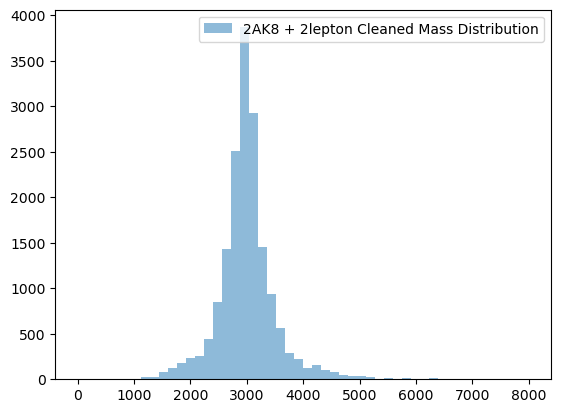

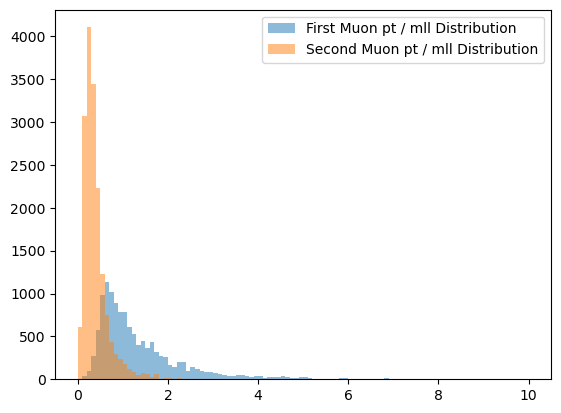

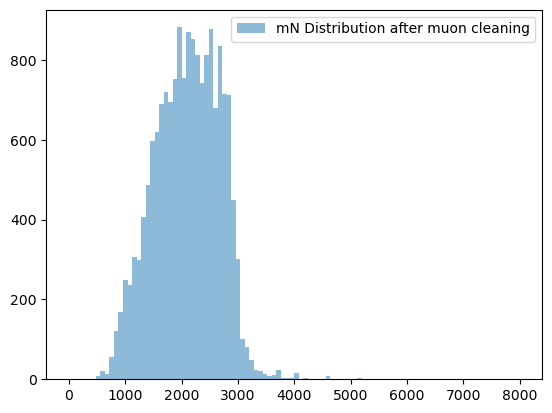

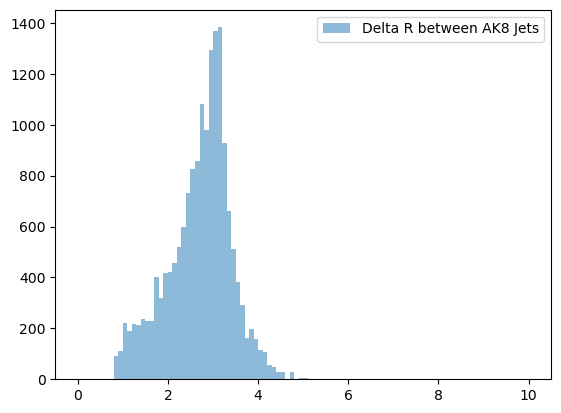

/tmp/ipykernel_3034549/3394394847.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


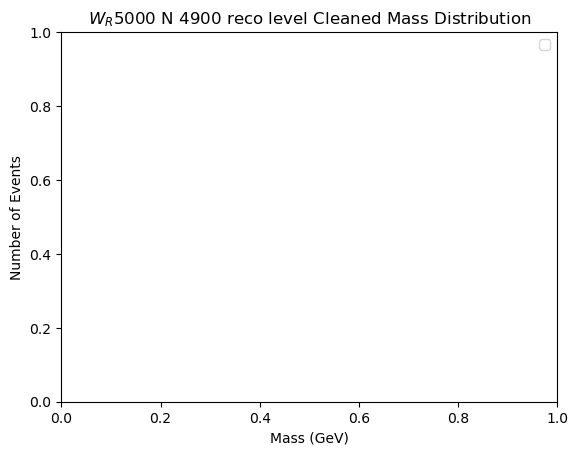

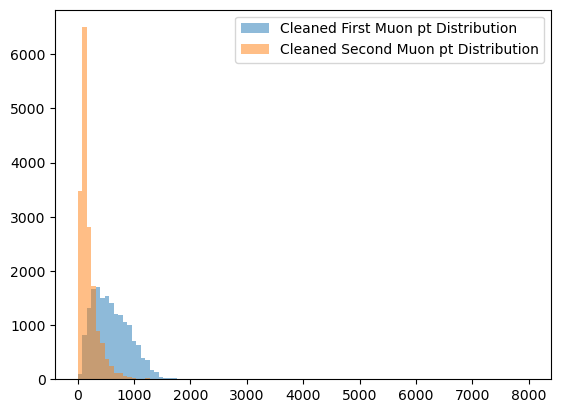

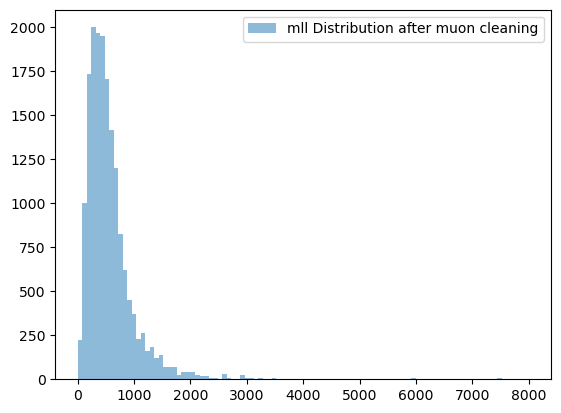

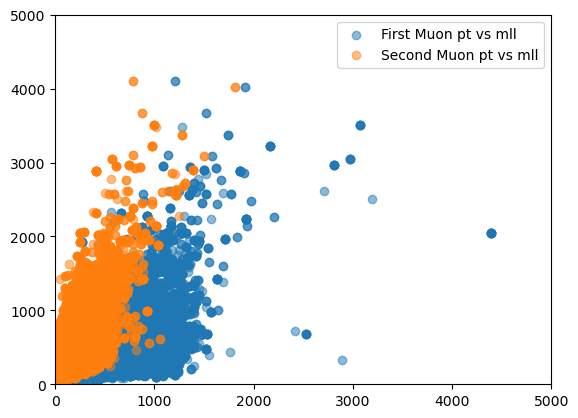

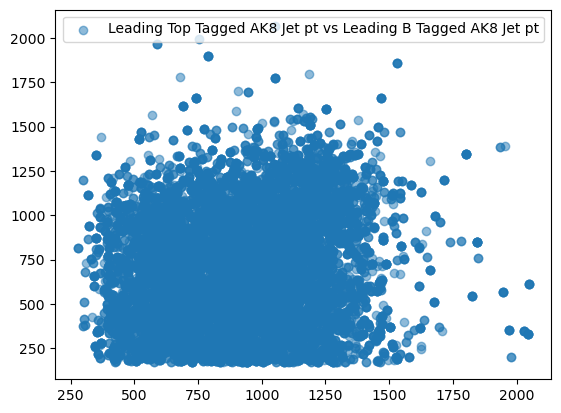

"\nplt.hist(all_combined_p4, bins=50, range=(0, 8000), alpha=0.5, label='2AK8 + 2lepton Cleaned Mass Distribution')\nplt.xlabel('Mass (GeV)')\nplt.ylabel('Number of Events')\nplt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')\n\nplt.hist(all_mN, bins=100, range=(0, 8000), alpha=0.5, label='mN Distribution after muon cleaning')\nplt.legend()\nplt.show()\nprint(len(all_combined_p4))\n\n## delta R between ak8 \n\nplt.hist(ak.flatten(all_ak8_deltaR), bins=100, range=(0, 10), alpha=0.5, label='Delta R between AK8 Jets')\nplt.legend()\nplt.show()\n\n##lepton pt \nplt.hist(ak.flatten(all_final_muon1_pt), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned First Muon pt Distribution')\nplt.hist(ak.flatten(all_final_muon2_pt), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Second Muon pt Distribution')\nplt.legend()\nplt.show()\n##mll\n\n\nplt.hist(all_mll, bins=100, range=(0, 8000), alpha=0.5, label='mll Distribution after muon cleaning')\nplt.legend()\nplt.show()\n\np

In [27]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt


all_combined = ak.concatenate(all_combined_p4)   # 이전에 chunked_combined_p4 리스트에 mass 덩어리들을 모아두었다고 가정
flat_mass = ak.to_numpy(all_combined)                  # NumPy 배열로 변환
all_mN = ak.to_numpy(ak.concatenate(all_mN))
all_deltaR = ak.to_numpy(ak.concatenate(all_ak8_deltaR))
all_mll = ak.to_numpy(ak.concatenate(all_mll))
all_final_muon1_pt = ak.to_numpy(ak.concatenate(all_final_muon1_pt))
all_final_muon2_pt = ak.to_numpy(ak.concatenate(all_final_muon2_pt))
all_final_toptagged_ak8_pt = ak.to_numpy(ak.concatenate(all_final_toptagged_ak8_pt))
all_final_bjet_ak8_pt = ak.to_numpy(ak.concatenate(all_final_bjet_ak8_pt))
ptdividebymll1 = np.array(all_final_muon1_pt) / np.array(all_mll)
ptdividebymll2 = np.array(all_final_muon2_pt) / np.array(all_mll)
plt.hist(flat_mass, bins=50, range=(0, 8000), alpha=0.5, label='2AK8 + 2lepton Cleaned Mass Distribution')
plt.legend()
plt.show()
plt.hist(ptdividebymll, bins=100, range=(0, 10), alpha=0.5, label='First Muon pt / mll Distribution')
plt.hist(ptdividebymll2, bins=100, range=(0, 10), alpha=0.5, label='Second Muon pt / mll Distribution')
plt.legend()
plt.show()


plt.hist(all_mN, bins=100, range=(0, 8000), alpha=0.5, label='mN Distribution after muon cleaning')
plt.legend()
plt.show()
plt.hist(all_deltaR, bins=100, range=(0, 10), alpha=0.5, label='Delta R between AK8 Jets')
plt.legend()
plt.show()
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')
plt.legend()
plt.show()
plt.hist(all_final_muon1_pt, bins=100, range=(0, 8000), alpha=0.5, label='Cleaned First Muon pt Distribution')
plt.hist(all_final_muon2_pt, bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Second Muon pt Distribution')
plt.legend()
plt.show()
plt.hist(all_mll, bins=100, range=(0, 8000), alpha=0.5, label='mll Distribution after muon cleaning')
plt.legend()
plt.show()
plt.scatter(all_final_muon1_pt, all_mll, alpha=0.5, label='First Muon pt vs mll')
plt.scatter(all_final_muon2_pt, all_mll, alpha=0.5, label='Second Muon pt vs mll')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.legend()
plt.show()
plt.scatter(all_final_toptagged_ak8_pt, all_final_bjet_ak8_pt, alpha=0.5, label='Leading Top Tagged AK8 Jet pt vs Leading B Tagged AK8 Jet pt')
plt.legend()
plt.show()
'''
plt.hist(all_combined_p4, bins=50, range=(0, 8000), alpha=0.5, label='2AK8 + 2lepton Cleaned Mass Distribution')
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')

plt.hist(all_mN, bins=100, range=(0, 8000), alpha=0.5, label='mN Distribution after muon cleaning')
plt.legend()
plt.show()
print(len(all_combined_p4))

## delta R between ak8 

plt.hist(ak.flatten(all_ak8_deltaR), bins=100, range=(0, 10), alpha=0.5, label='Delta R between AK8 Jets')
plt.legend()
plt.show()

##lepton pt 
plt.hist(ak.flatten(all_final_muon1_pt), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned First Muon pt Distribution')
plt.hist(ak.flatten(all_final_muon2_pt), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Second Muon pt Distribution')
plt.legend()
plt.show()
##mll


plt.hist(all_mll, bins=100, range=(0, 8000), alpha=0.5, label='mll Distribution after muon cleaning')
plt.legend()
plt.show()

plt.scatter(ak.flatten(all_final_muon1_pt), mll ,alpha=0.5, label='First Muon pt vs mll')
plt.scatter(ak.flatten(all_final_muon2_pt), mll, alpha=0.5, label='Second Muon pt vs mll')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.legend()
plt.show()

plt.scatter(ak.flatten(all_final_toptagged_ak8_pt), ak.flatten(all_final_bjet_ak8_pt), alpha=0.5, label='Leading Top Tagged AK8 Jet pt vs Leading B Tagged AK8 Jet pt')
plt.show()
'''

In [1]:
## background test

In [2]:
ls


copy_sample.sh
DYto2L-2Jets_MLL-10to50_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-2Jets_MLL-4to10_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-2Jets_MLL-50_0J_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-2Jets_MLL-50_1J_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-2Jets_MLL-50_2J_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-2Jets_MLL-50_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-4Jets_MLL-50_TuneCP5_13p6TeV_madgraphMLM-pythia8/
GluGluHto2B_M-125_TuneCP5_13p6TeV_powheg-minlo-pythia8/
GluGluHto2C_M-125_TuneCP5_13p6TeV_powheg-minlo-pythia8/
GluGluHto2E_M-125_TuneCP5_13p6TeV_amcatnloFxFx-pythia8/
GluGluHto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/
GluGluHto2Wto2L2Nu_M-125_TuneCP5_13p6TeV_powheg-jhugen752-pythia8/
GluGluHto2Zto4Nu_PT-150_M-125_TuneCP5_13p6TeV_powheg-pythia8/
GluGluHtoZZto4L_M-125_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/
JpsiTo2Mu_JpsiPt8_TuneCP5_13p6TeV_pythia8/
QCD-4Jets_HT-1000to1200_TuneCP5_13p6TeV_madgraphMLM-pythia8/
QCD-4Jets_HT-100to200_TuneCP5_13p6TeV_madgraph

first muon cleaned [[{pt: 551, eta: -0.396, phi: 2.04, mass: 0.106}], ..., [{pt: 632, ...}]]
[[False, True, False, False], [None, None, None], ..., [...], [True, False]]
[[2.22e+03], [None], [1.53e+03], [None], ..., [None], [580], [416], [2.07e+03]]
[[2.39e+03], [None], [1.98e+03], [None], ..., [1.36e+03], [876], [1.55e+03]]


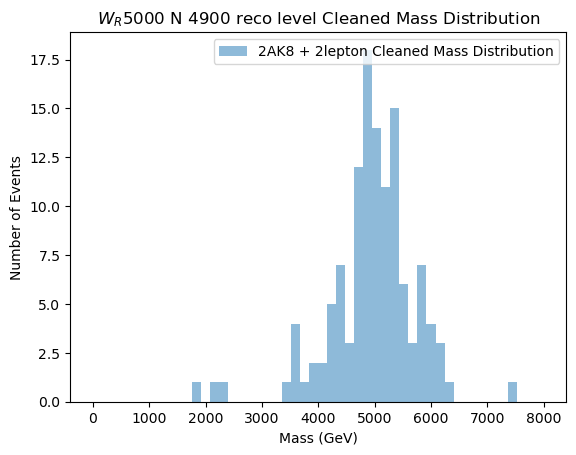

127


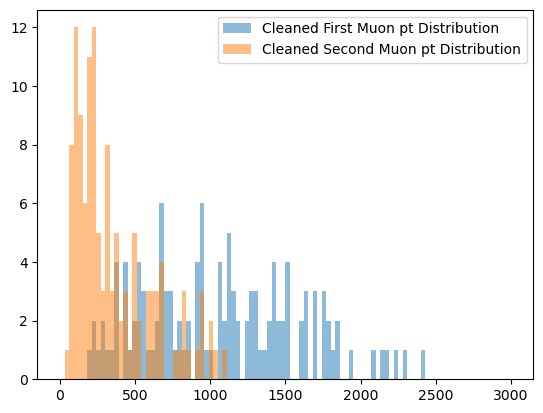

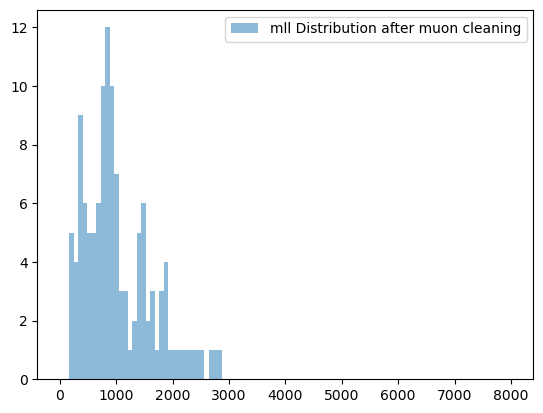

"\n## delta R between ak8 \nak8_deltaR = leading_toptagged_ak8.deltaR(leading_bjet_ak8)\nplt.hist(ak.flatten(ak8_deltaR), bins=100, range=(0, 10), alpha=0.5, label='Delta R between AK8 Jets')\nplt.legend()\nplt.show()\n"

In [53]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()
## main back  = ttH , ttZ , ttW , ttbar , tzj
#/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root
#/gv0/Users/achihwan/TbarWplusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_18.root
#/gv0/Users/achihwan/TbarWplustoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/tree_100.root
#/gv0/Users/achihwan/TTH_Hto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root
#/gv0/Users/achihwan/TTH_Hto2Z_M-125_4LFilter_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/tree_13.root
#/gv0/Users/achihwan/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root
sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root"
file = uproot.open(sample)
events = file["Events"]

keys = events.keys()

def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]

def btagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btagging[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btagging[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj["eta"]) < etamax and obj["pt"] > ptmin : output.append(obj)
    return output 





lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()

bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

lhe_particle  = ak.zip({
    "pt": lhe_pt,
    "eta": lhe_eta,
    "phi": lhe_phi,
    "mass": lhe_mass
}, with_name = "Momentum4D")

lhe_bottoms = lhe_particle[bottom_mask]
lhe_bottoms_eta = lhe_bottoms["eta"][:, 1:2]  
lhe_bottoms_phi = lhe_bottoms["phi"][:, 1:2]
lhe_bottoms_pt = lhe_bottoms["pt"][:, 1:2]  
lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]  # bottom quark 1 = WR* mother

lhe_bottom2_eta = lhe_bottoms["eta"][:, 0:1]
lhe_bottom2_phi = lhe_bottoms["phi"][:, 0:1]
lhe_bottom2_pt = lhe_bottoms["pt"][:, 0:1]
lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]  # top mother bottom quark

lhe_bottom = ak.zip({
    "eta": lhe_bottoms_eta,
    "phi": lhe_bottoms_phi,
    "pt": lhe_bottoms_pt,
    "mass": lhe_bottoms_mass
}, with_name = "Momentum4D")

lhe_bottom2 = ak.zip({
    "eta": lhe_bottom2_eta,
    "phi": lhe_bottom2_phi,
    "pt": lhe_bottom2_pt,
    "mass": lhe_bottom2_mass
}, with_name = "Momentum4D")

lhe_muons  = lhe_particle[lhe_muon_mask]
lhe_muons_eta = lhe_muons["eta"][:]
lhe_muons_phi = lhe_muons["phi"][:]
lhe_muons_pt = lhe_muons["pt"][:]
lhe_muons_mass = lhe_muons["mass"][:]

n_mother_muon_mass = lhe_muons_mass[:,0:1] 
n_mother_muon_pt = lhe_muons_pt[:,0:1] 
n_mother_muon_eta = lhe_muons_eta[:,0:1]
n_mother_muon_phi = lhe_muons_phi[:,0:1]

wr_mother_muon_mass = lhe_muons_mass[:,1:2]
wr_mother_muon_pt = lhe_muons_pt[:,1:2]
wr_mother_muon_eta = lhe_muons_eta[:,1:2]
wr_mother_muon_phi = lhe_muons_phi[:,1:2]

lhe_muon = ak.zip({
    "pt": lhe_muons_pt,
    "eta": lhe_muons_eta,
    "phi": lhe_muons_phi,
    "mass": lhe_muons_mass
}, with_name = "Momentum4D")

n_mother_muon = ak.zip({
    "pt": n_mother_muon_pt,
    "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
    "mass": n_mother_muon_mass
}, with_name = "Momentum4D")

wr_mother_muon = ak.zip({
    "pt": wr_mother_muon_pt,
    "eta": wr_mother_muon_eta,
    "phi": wr_mother_muon_phi,
    "mass": wr_mother_muon_mass
}, with_name = "Momentum4D")



genparticle_pdgid = events["GenPart_pdgId"].array()
genparticle_pt = events["GenPart_pt"].array()
genparticle_eta = events["GenPart_eta"].array()
genparticle_phi = events["GenPart_phi"].array()
genparticle_mass = events["GenPart_mass"].array()
genparticle_statusFlags = events["GenPart_statusFlags"].array()

top_mask = (genparticle_pdgid == 6) | (genparticle_pdgid == -6)


genparticle  = ak.zip({
    "pt": genparticle_pt,
    "eta": genparticle_eta,
    "phi": genparticle_phi,
    "mass": genparticle_mass
}, with_name = "Momentum4D")



gentops = genparticle[top_mask]
gentops_eta = gentops["eta"][:, 0:1]  
gentops_phi = gentops["phi"][:, 0:1]
gentops_pt = gentops["pt"][:, 0:1]  
gentops_mass = gentops["mass"][:, 0:1]  


gentop = ak.zip({
    "eta": gentops_eta,
    "phi": gentops_phi,
    "pt": gentops_pt,
    "mass": gentops_mass
}, with_name = "Momentum4D")


### reco level
ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

## muons
reco_muon_pt = events["Muon_pt"].array()
reco_muon_eta = events["Muon_eta"].array()
reco_muon_phi = events["Muon_phi"].array()
reco_muon_mass = events["Muon_mass"].array()

reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")


btagging = events["FatJet_btagDeepB"].array()
toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
softdrop_mass = events["FatJet_msoftdrop"].array()

closest_muon1 = find_closest_jet(n_mother_muon, reco_muons)
closest_muon2 = find_closest_jet(wr_mother_muon, reco_muons)
closest_bjet = find_closest_jet(lhe_bottom, ak4)
closest_bak8jet = find_closest_jet(lhe_bottom, fatjets)
closest_ak8jet = find_closest_jet(gentop, fatjets)
#notcleaned_mass = closest_muon1 + closest_muon2 + closest_bjet + closest_ak8jet
#plt.hist(notcleaned_mass.mass, bins=100, range=(0, 8000), alpha=0.5, label='Not Cleaned Mass Distribution')
#####################################################
cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []
cleaned_ak4jet_pt = []
all_ak4jet_pt = []
cleaned_ak8jet_pt =[]
all_ak8jet_pt = []
#####################################################


first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온

topmother_b_ak4jet = find_closest_jet(lhe_bottom2, ak4)
### 겹치는거 확인 

first_muon_cleaned = overlap_removal(first_muon, [reco_muons], cut=0.4)
second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)
print("first muon cleaned", first_muon_cleaned)



signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
toptaggedak8 = toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
softdrop_mass_ak8 = sdm_toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
btaggingak8 = btagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)

idx_desc = ak.argsort(-signaltop_cleaned["pt"], axis=1)

toptagging_mask = toptaggedak8 > 0.9  # ParticleNet T vs QCD threshold
softdrop_mass_mask = (softdrop_mass_ak8 > 120) & (softdrop_mass_ak8 < 250)   # SoftDrop mass threshold
total_top_mask = toptagging_mask & softdrop_mass_mask
print(total_top_mask)
cleaned_toptagged_ak8 = signaltop_cleaned[total_top_mask]  # top tagging 된 애들만 남김
idx_cleaned_toptagged_ak8 = ak.argsort(-cleaned_toptagged_ak8["pt"], axis=1)
leading_toptagged_ak8 = cleaned_toptagged_ak8[idx_cleaned_toptagged_ak8][:, 0:1]  # 가장 큰 pt

## top을 제외한 나머지 ak8 중 제일 큰 pt

cleaned_bjet_ak8 = signaltop_cleaned[~toptagging_mask]
idx_cleaned_bjet_ak8 = ak.argsort(-cleaned_bjet_ak8["pt"], axis=1)
leading_bjet_ak8 = cleaned_bjet_ak8[idx_cleaned_bjet_ak8][:, 0:1]  # 가장 큰 pt

print(leading_toptagged_ak8["pt"])
print(leading_bjet_ak8["pt"])
#plt.hist(ak.flatten(leading_toptagged_ak8["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Leading Top Tagged AK8 Jet pt Distribution')
#plt.hist(ak.flatten(closest_ak8jet["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Leading Top Tagged AK8 Jet pt Distribution')
#plt.hist(ak.flatten(leading_bjet_ak8["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Leading B Tagged AK8 Jet pt Distribution')
#plt.hist(ak.flatten(closest_bak8jet["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Leading B Tagged AK8 Jet pt Distribution')



#print(btaggingak8[~toptagging_mask])# top tagging 된 애들 제외하고 B tagging 점수 
#print("bjet tagged",ak.firsts(btaggingak8[~toptagging_mask]))
#plt.hist(ak.firsts(btaggingak8[~toptagging_mask]), bins=100, range=(0, 1), alpha=0.5, label='B tag score ak8 jet Distribution')
#plt.legend()
#plt.show()
#print("cleaned top tagged pt",signaltop_cleaned[toptagging_mask]["pt"])

#print( sum(1 for sub in signaltop_cleaned["pt"] if len(sub) >= 2))
### 빈 이벤트 빼고 연산하는 마스크 만들기
first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
firstsorted_toptagged_ak8_pt = ak.sum(leading_toptagged_ak8["pt"], axis=1)
firstsorted_bjet_ak8_pt = ak.sum(leading_bjet_ak8["pt"], axis=1)

first_muon_cleaned_eta = ak.sum(first_muon_cleaned["eta"], axis=1)
second_muon_cleaned_eta = ak.sum(second_muon_cleaned["eta"], axis=1)
firstsorted_toptagged_ak8_eta = ak.sum(leading_toptagged_ak8["eta"], axis=1)
firstsorted_bjet_ak8_eta = ak.sum(leading_bjet_ak8["eta"], axis=1)


leftmask = (first_muon_cleaned_pt > 60.0) & (second_muon_cleaned_pt > 53.0) & (firstsorted_toptagged_ak8_pt > 0.0) & (firstsorted_bjet_ak8_pt > 0.0) & (abs(first_muon_cleaned_eta) < 2.4) & (abs(second_muon_cleaned_eta) < 2.4)
#print(len(firstsorted_ak8_pt > 0))
first_muon_cleaned = first_muon_cleaned[leftmask]
second_muon_cleaned = second_muon_cleaned[leftmask]
leading_toptagged_ak8 = leading_toptagged_ak8[leftmask]
leading_bjet_ak8 = leading_bjet_ak8[leftmask]

mll = (first_muon_cleaned + second_muon_cleaned).mass
mll_mask = mll > 200.0
first_muon_cleaned = first_muon_cleaned[mll_mask]
second_muon_cleaned = second_muon_cleaned[mll_mask]
leading_toptagged_ak8 = leading_toptagged_ak8[mll_mask]
leading_bjet_ak8 = leading_bjet_ak8[mll_mask]

combined_p4 = first_muon_cleaned + second_muon_cleaned + leading_toptagged_ak8 + leading_bjet_ak8
plt.hist(ak.flatten(combined_p4.mass), bins=50, range=(0, 8000), alpha=0.5, label='2AK8 + 2lepton Cleaned Mass Distribution')
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')
mN = (first_muon_cleaned + leading_toptagged_ak8 + leading_bjet_ak8).mass
#plt.hist(mN, bins=100, range=(0, 8000), alpha=0.5, label='mN Distribution after muon cleaning')
plt.legend()
plt.show()
print(len(combined_p4.mass))


##lepton pt 
plt.hist(ak.flatten(first_muon_cleaned["pt"]), bins=100, range=(0, 3000), alpha=0.5, label='Cleaned First Muon pt Distribution')
plt.hist(ak.flatten(second_muon_cleaned["pt"]), bins=100, range=(0, 3000), alpha=0.5, label='Cleaned Second Muon pt Distribution')
plt.legend()
plt.show()
##mll

mll = (first_muon_cleaned + second_muon_cleaned).mass
plt.hist(ak.flatten(mll), bins=100, range=(0, 8000), alpha=0.5, label='mll Distribution after muon cleaning')
plt.legend()
plt.show()

'''
## delta R between ak8 
ak8_deltaR = leading_toptagged_ak8.deltaR(leading_bjet_ak8)
plt.hist(ak.flatten(ak8_deltaR), bins=100, range=(0, 10), alpha=0.5, label='Delta R between AK8 Jets')
plt.legend()
plt.show()
'''

In [10]:
cd /gv0/Users/achihwan/

/gv0/Users/achihwan


/home/achihwan/miniconda3/envs/hep_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [19]:
ls

copy_sample.sh
DYto2L-2Jets_MLL-10to50_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-2Jets_MLL-4to10_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-2Jets_MLL-50_0J_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-2Jets_MLL-50_1J_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-2Jets_MLL-50_2J_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-2Jets_MLL-50_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/
DYto2L-4Jets_MLL-50_TuneCP5_13p6TeV_madgraphMLM-pythia8/
GluGluHto2B_M-125_TuneCP5_13p6TeV_powheg-minlo-pythia8/
GluGluHto2C_M-125_TuneCP5_13p6TeV_powheg-minlo-pythia8/
GluGluHto2E_M-125_TuneCP5_13p6TeV_amcatnloFxFx-pythia8/
GluGluHto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/
GluGluHto2Wto2L2Nu_M-125_TuneCP5_13p6TeV_powheg-jhugen752-pythia8/
GluGluHto2Zto4Nu_PT-150_M-125_TuneCP5_13p6TeV_powheg-pythia8/
GluGluHtoZZto4L_M-125_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/
JpsiTo2Mu_JpsiPt8_TuneCP5_13p6TeV_pythia8/
QCD-4Jets_HT-1000to1200_TuneCP5_13p6TeV_madgraphMLM-pythia8/
QCD-4Jets_HT-100to200_TuneCP5_13p6TeV_madgraph

In [2]:
#### b tagging ( ak4 + ak8)

muon_num2_mask [True, True, True, True, True, True, ..., True, True, True, True, True, True]
first muon cleaned [[1.51e+03], [462], [2.4e+03], [1.07e+03], ..., [1.09e+03], [1.44e+03], [684]]


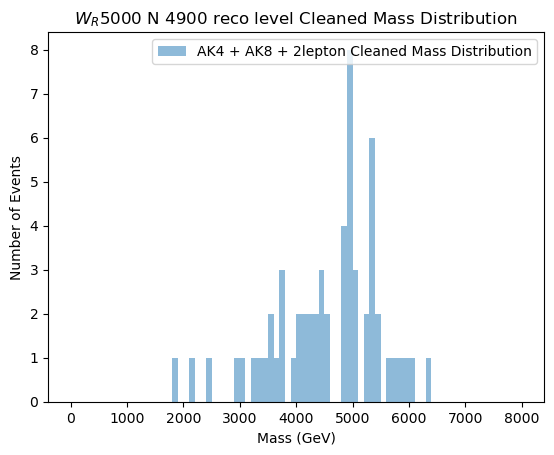

62


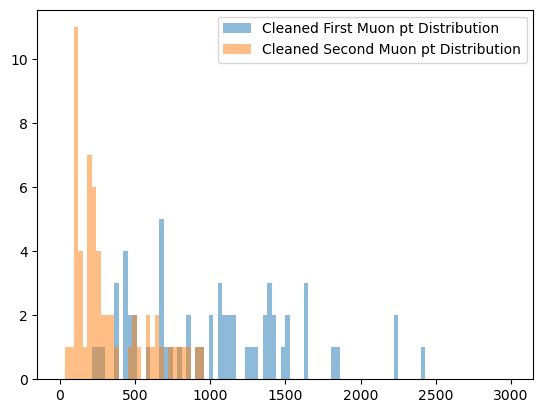

mll [[2.33e+03], [529], [269], [1.19e+03], ..., [345], [1.03e+03], [804], [443]]


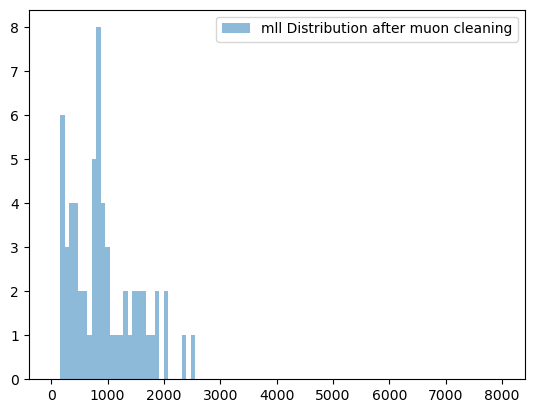

In [54]:
from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()
## main back  = ttH , ttZ , ttW , ttbar , tzj
#/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root
#/gv0/Users/achihwan/TbarWplusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_18.root
#/gv0/Users/achihwan/TbarWplustoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/tree_100.root
#/gv0/Users/achihwan/TTH_Hto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root
#/gv0/Users/achihwan/TTH_Hto2Z_M-125_4LFilter_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/tree_13.root
#/gv0/Users/achihwan/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root
#/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/using_matrix/cleaning/backgroundsample/08528f47-e513-4c27-9e86-a76cdca78fe8.root  ttz->mu
sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root"
file = uproot.open(sample)
events = file["Events"]

keys = events.keys()

btag = events["Jet_btagPNetB"].array()
def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]
def btag4_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btag[mask]
def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]
def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]

def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btag[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj.eta) < etamax and obj.pt > ptmin : output.append(obj)
    return output 





lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()

bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

lhe_particle  = ak.zip({
    "pt": lhe_pt,
    "eta": lhe_eta,
    "phi": lhe_phi,
    "mass": lhe_mass
}, with_name = "Momentum4D")

lhe_bottoms = lhe_particle[bottom_mask]
lhe_bottoms_eta = lhe_bottoms["eta"][:, 1:2]  
lhe_bottoms_phi = lhe_bottoms["phi"][:, 1:2]
lhe_bottoms_pt = lhe_bottoms["pt"][:, 1:2]  
lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]  # bottom quark 1 = WR* mother

lhe_bottom2_eta = lhe_bottoms["eta"][:, 0:1]
lhe_bottom2_phi = lhe_bottoms["phi"][:, 0:1]
lhe_bottom2_pt = lhe_bottoms["pt"][:, 0:1]
lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]  # top mother bottom quark

lhe_bottom = ak.zip({
    "eta": lhe_bottoms_eta,
    "phi": lhe_bottoms_phi,
    "pt": lhe_bottoms_pt,
    "mass": lhe_bottoms_mass
}, with_name = "Momentum4D")

lhe_bottom2 = ak.zip({
    "eta": lhe_bottom2_eta,
    "phi": lhe_bottom2_phi,
    "pt": lhe_bottom2_pt,
    "mass": lhe_bottom2_mass
}, with_name = "Momentum4D")

lhe_muons  = lhe_particle[lhe_muon_mask]
lhe_muons_eta = lhe_muons["eta"][:]
lhe_muons_phi = lhe_muons["phi"][:]
lhe_muons_pt = lhe_muons["pt"][:]
lhe_muons_mass = lhe_muons["mass"][:]

n_mother_muon_mass = lhe_muons_mass[:,0:1] 
n_mother_muon_pt = lhe_muons_pt[:,0:1] 
n_mother_muon_eta = lhe_muons_eta[:,0:1]
n_mother_muon_phi = lhe_muons_phi[:,0:1]

wr_mother_muon_mass = lhe_muons_mass[:,1:2]
wr_mother_muon_pt = lhe_muons_pt[:,1:2]
wr_mother_muon_eta = lhe_muons_eta[:,1:2]
wr_mother_muon_phi = lhe_muons_phi[:,1:2]

lhe_muon = ak.zip({
    "pt": lhe_muons_pt,
    "eta": lhe_muons_eta,
    "phi": lhe_muons_phi,
    "mass": lhe_muons_mass
}, with_name = "Momentum4D")

n_mother_muon = ak.zip({
    "pt": n_mother_muon_pt,
    "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
    "mass": n_mother_muon_mass
}, with_name = "Momentum4D")

wr_mother_muon = ak.zip({
    "pt": wr_mother_muon_pt,
    "eta": wr_mother_muon_eta,
    "phi": wr_mother_muon_phi,
    "mass": wr_mother_muon_mass
}, with_name = "Momentum4D")



genparticle_pdgid = events["GenPart_pdgId"].array()
genparticle_pt = events["GenPart_pt"].array()
genparticle_eta = events["GenPart_eta"].array()
genparticle_phi = events["GenPart_phi"].array()
genparticle_mass = events["GenPart_mass"].array()
genparticle_statusFlags = events["GenPart_statusFlags"].array()

top_mask = (genparticle_pdgid == 6) | (genparticle_pdgid == -6)


genparticle  = ak.zip({
    "pt": genparticle_pt,
    "eta": genparticle_eta,
    "phi": genparticle_phi,
    "mass": genparticle_mass
}, with_name = "Momentum4D")



gentops = genparticle[top_mask]
gentops_eta = gentops["eta"][:, 0:1]  
gentops_phi = gentops["phi"][:, 0:1]
gentops_pt = gentops["pt"][:, 0:1]  
gentops_mass = gentops["mass"][:, 0:1]  


gentop = ak.zip({
    "eta": gentops_eta,
    "phi": gentops_phi,
    "pt": gentops_pt,
    "mass": gentops_mass
}, with_name = "Momentum4D")


### reco level
ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

## muons
reco_muon_pt = events["Muon_pt"].array()
reco_muon_eta = events["Muon_eta"].array()
reco_muon_phi = events["Muon_phi"].array()
reco_muon_mass = events["Muon_mass"].array()

reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")



closest_muon1 = find_closest_jet(n_mother_muon, reco_muons)
closest_muon2 = find_closest_jet(wr_mother_muon, reco_muons)
closest_bjet = find_closest_jet(lhe_bottom, ak4)
closest_ak8jet = find_closest_jet(gentop, fatjets)
#notcleaned_mass = closest_muon1 + closest_muon2 + closest_bjet + closest_ak8jet
#####################################################
cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []
cleaned_ak4jet_pt = []
all_ak4jet_pt = []
cleaned_ak8jet_pt =[]
all_ak8jet_pt = []
#####################################################



muon_num2_mask = ak.num(reco_muons["pt"]) > 1
print("muon_num2_mask",muon_num2_mask)

first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온

topmother_b_ak4jet = find_closest_jet(lhe_bottom2, ak4)
### 겹치는거 확인 

first_muon_cleaned = overlap_removal(first_muon, [reco_muons], cut=0.4)
second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)

### ak4 중에서 렙톤 근처에 없고 근처에 ak4없는것 중에 제일 큰 pt
signalb_cleaned = overlap_removal(ak4, [reco_muons, ak4], cut=0.4)
btaggedb_cleaned = btag4_overlap_removal(ak4, [first_muon_cleaned,second_muon_cleaned, ak4], cut=0.4)


sortidx = ak.argsort(-signalb_cleaned["pt"], axis=1)  # pt 기준으로 내림차순 정렬
signalb_cleaend_sorted = signalb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택

sorted_btaggedb_cleaned = btaggedb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택
sorted_btaggedb_cleaned2 = btaggedb_cleaned[sortidx][:, 1:2]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택


btagging = sorted_btaggedb_cleaned > 0.5
signalb_cleaend_sorted = signalb_cleaend_sorted[btagging]
sortidx = ak.argsort(-signalb_cleaend_sorted["pt"], axis=1)  # pt 기준으로 내림차순 정렬
leading_tagged_bjet = signalb_cleaend_sorted[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택


closest_bjet = find_closest_jet(lhe_bottom, ak4)

toptaggedak8 = toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned,leading_tagged_bjet, fatjets], cut=0.8)
softdrop_mass_ak8 = sdm_toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)


#sortidx8 = ak.argsort(-signaltop_cleaned["pt"], axis=1)  # pt 기준으로 내림차순 정렬
#signaltop_cleaned_sorted = signaltop_cleaned[sortidx8][:, 0:1]
sortidx8 = ak.argsort(-signaltop_cleaned["pt"], axis=1)

toptagging_mask = toptaggedak8 > 0.9  # ParticleNet T vs QCD threshold
softdrop_mass_mask = (softdrop_mass_ak8 > 120) & (softdrop_mass_ak8 < 250)  # SoftDrop mass threshold

total_top_mask = toptagging_mask & softdrop_mass_mask

cleaned_toptagged_ak8 = signaltop_cleaned[total_top_mask]  # top tagging 된 애들만 남김
idx_cleaned_toptagged_ak8 = ak.argsort(-cleaned_toptagged_ak8["pt"], axis=1)
leading_toptagged_ak8 = cleaned_toptagged_ak8[idx_cleaned_toptagged_ak8][:, 0:1]  # 가장 큰 pt

closest_ak8jet = find_closest_jet(gentop, fatjets)



### 빈 이벤트 빼고 연산하는 마스크 만들기
first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
signalb_cleaned_pt = ak.sum(leading_tagged_bjet["pt"], axis=1)
signaltop_cleaned_pt = ak.sum(leading_toptagged_ak8["pt"], axis=1)

first_muon_cleaned_eta = ak.sum(first_muon_cleaned["eta"], axis=1)
second_muon_cleaned_eta = ak.sum(second_muon_cleaned["eta"], axis=1)
firstsorted_toptagged_ak8_eta = ak.sum(leading_toptagged_ak8["eta"], axis=1)
firstsorted_bjet_ak8_eta = ak.sum(leading_bjet_ak8["eta"], axis=1)

leftmask = (first_muon_cleaned_pt > 60.0) & (second_muon_cleaned_pt > 53.0) & (signalb_cleaned_pt > 0.0) & (signaltop_cleaned_pt > 0.0) & (abs(first_muon_cleaned_eta) < 2.4) & (abs(second_muon_cleaned_eta) < 2.4)
first_muon_cleaned = first_muon_cleaned[leftmask]
second_muon_cleaned = second_muon_cleaned[leftmask]
signalb_cleaend_sorted = leading_tagged_bjet[leftmask]
signaltop_cleaned_sorted = leading_toptagged_ak8[leftmask]
print("first muon cleaned", first_muon_cleaned["pt"])
mll = (first_muon_cleaned + second_muon_cleaned).mass
mll_mask = mll > 200.0
first_muon_cleaned = first_muon_cleaned[mll_mask]
second_muon_cleaned = second_muon_cleaned[mll_mask]
signalb_cleaend_sorted = signalb_cleaend_sorted[mll_mask]
signaltop_cleaned_sorted = signaltop_cleaned_sorted[mll_mask]

combined_p4 = first_muon_cleaned + second_muon_cleaned + signalb_cleaend_sorted + signaltop_cleaned_sorted

plt.hist(ak.flatten(combined_p4.mass), bins=80, range=(0, 8000), alpha=0.5, label='AK4 + AK8 + 2lepton Cleaned Mass Distribution')
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')
plt.legend()
mN = (first_muon_cleaned + signalb_cleaend_sorted + signaltop_cleaned_sorted).mass
#plt.hist(mN, bins=100, range=(0, 8000), alpha=0.5, label='mN Distribution after muon cleaning')
plt.show()
print(len(combined_p4.mass))
#lhe_combined_p4 = n_mother_muon + wr_mother_muon + lhe_bottom + gentop


##lepton pt
plt.hist(ak.flatten(first_muon_cleaned["pt"]), bins=100, range=(0, 3000), alpha=0.5, label='Cleaned First Muon pt Distribution')
plt.hist(ak.flatten(second_muon_cleaned["pt"]), bins=100, range =(0, 3000), alpha=0.5, label='Cleaned Second Muon pt Distribution')
plt.legend()

##
plt.show()


print("mll", mll)
plt.hist(mll, bins=100, range=(0, 8000), alpha=0.5, label='mll Distribution after muon cleaning')
plt.legend()
plt.show()
